# Training HuggingFace models in google colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10kGk_-X2F2gEOpyGpJLm-viy7tp72-II?usp=sharing)



In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from src.utils import load_dataset
from src import utils, huggingface

pd.set_option('display.max_colwidth', None)

## Raw labels

First evaluate the raw labels, without the aggregation

In [2]:
# for each model and epoch, get the predictions on both validation_set and evaluation_set and compute f1_score
all_values = []
for epoch in [1,2,3,4]:
    values = huggingface.evaluate_pipe('raw_label', epoch)
    all_values.append({'epoch': epoch, **values})
    
pd.DataFrame(all_values)
# everything matches

,epoch,f1_validation,f1_evaluation,f1_average
0,1,0.789536,0.867925,0.828730
1,2,0.819090,0.842105,0.830598
2,3,0.790974,0.905660,0.848317
3,4,0.799534,0.888889,0.844211


# Majority vote

In [3]:
all_values = []
for epoch in [1,2,3,4]:
    values = huggingface.evaluate_pipe('m_vote_strict', epoch)
    all_values.append({'epoch': epoch, **values})
    
pd.DataFrame(all_values)
# everything matches

,epoch,f1_validation,f1_evaluation,f1_average
0,1,0.735586,0.884615,0.810101
1,2,0.771800,0.867925,0.819862
2,3,0.734531,0.857143,0.795837
3,4,0.767486,0.851852,0.809669


In [4]:
all_values = []
for epoch in [1,2,3,4]:
    values = huggingface.evaluate_pipe('m_vote_nonstrict', epoch)
    all_values.append({'epoch': epoch, **values})
    
pd.DataFrame(all_values)
# everything matches

,epoch,f1_validation,f1_evaluation,f1_average
0,1,0.799353,0.857143,0.828248
1,2,0.825040,0.827586,0.826313
2,3,0.830861,0.825397,0.828129
3,4,0.841941,0.866667,0.854304


## Regression on weighted majority vote

In [5]:
all_values = []
for epoch in [1,2,3,4]:
    values = huggingface.evaluate_pipe('regression_w_m_vote', epoch)
    for t, t_values in values.items():
        all_values.append({'epoch': epoch, 'threshold': t, **t_values})
    
df = pd.DataFrame(all_values)

## Weighted majority vote strict/nonstrict

In [6]:
all_values = []
for epoch in [1,2,3,4]:
    values = huggingface.evaluate_pipe('w_m_vote_strict', epoch)
    all_values.append({'epoch': epoch, **values})
    
pd.DataFrame(all_values)
# everything matches

,epoch,f1_validation,f1_evaluation,f1_average
0,1,0.780316,0.867925,0.824120
1,2,0.834862,0.852459,0.843661
2,3,0.845201,0.847458,0.846329
3,4,0.821830,0.888889,0.855359


In [7]:
all_values = []
for epoch in [1,2,3,4]:
    values = huggingface.evaluate_pipe('w_m_vote_nonstrict', epoch)
    all_values.append({'epoch': epoch, **values})
    
pd.DataFrame(all_values)
# everything matches

,epoch,f1_validation,f1_evaluation,f1_average
0,1,0.846954,0.813559,0.830257
1,2,0.836923,0.900000,0.868462
2,3,0.841782,0.881356,0.861569
3,4,0.828250,0.896552,0.862401


# Performance evaluation


# Threshold analysis


In [3]:
thr_analysis = pd.read_csv('./model/thr_analysis_w_m_vote.csv')
thr_analysis.set_index('Thr', inplace=True)
thr_analysis.head()

,Test,1,2,3,4
Thr,,,,,
0.10,labels_racism_0.1,0.685185,0.719512,0.685979,0.685185
0.10,evaluation_sample,0.627907,0.650602,0.627907,0.627907
0.10,Average,0.656546,0.685057,0.656943,0.656546
0.15,labels_racism_0.1,0.692398,0.795115,0.790823,0.790761
0.15,evaluation_sample,0.627907,0.739726,0.710526,0.710526


In [13]:
thr_analysis["Test"].replace({"labels_racism_0.1":"validation", 
                              "evaluation_sample": "evaluation", "Average": "average"}, inplace=True)

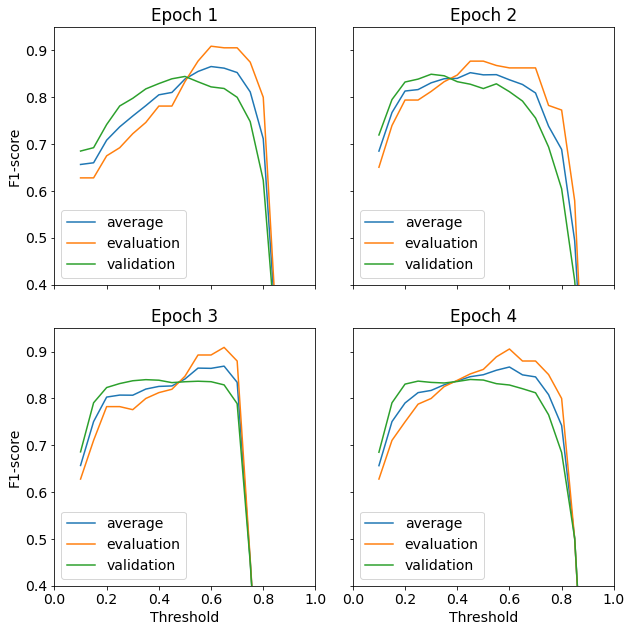

In [14]:


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex=True, sharey=True,figsize=(9,9))

thr_analysis.groupby('Test')['1'].plot(legend=True, ylim=[0.4,0.95], xlim=[0.0,1.0], ax=ax1)
ax1.set_title('Epoch 1')
ax1.set_ylabel('F1-score')
thr_analysis.groupby('Test')['2'].plot(legend=True, ylim=[0.4,0.95], xlim=[0.0,1.0], ax=ax2)
ax2.set_title('Epoch 2')
thr_analysis.groupby('Test')['3'].plot(legend=True, ylim=[0.4,0.95], xlim=[0.0,1.0], ax=ax3)
ax3.set_title('Epoch 3')
ax3.set_ylabel('F1-score')
ax3.set_xlabel('Threshold')
thr_analysis.groupby('Test')['4'].plot(legend=True, ylim=[0.4,0.95], xlim=[0.0,1.0], ax=ax4)
ax4.set_title('Epoch 4')
ax4.set_xlabel('Threshold')

plt.tight_layout()
fig.savefig('model/thr_analysis_w_m_vote.png')




# Error analysis


Evaluation sample translated has the english message and the toxicity scores generated with the src/perspective_api.ipynb.

In [3]:
IMPORT_PATH = os.path.join("data", "toxicity_scores")
EVAL_PATH = os.path.join(IMPORT_PATH, "evaluation_sample_translated.csv")

pred_tags = ['raw', 'm_vote_nonstrict', 'w_m_vote_nonstrict']
thr = 0.8


eval_df = load_dataset(EVAL_PATH)

predictions = {}
for pred_tag in pred_tags:
    predictions[pred_tag] = load_dataset(os.path.join(IMPORT_PATH, f"evaluation_sample_{pred_tag}.csv"))
    eval_df[pred_tag] = predictions[pred_tag]["predicted_label"]

n_total = eval_df.shape[0]
print(f"Evaluation sample: {n_total}")
eval_df.head()


Evaluation sample: 59


,message,english_message,label,toxicity,severe_toxicity,raw,m_vote_nonstrict,w_m_vote_nonstrict
0,"Feméride' (DCV): hoy se cumplen 60 años del estreno de ""libertad bajo palabra"" de Alfredo Bettanín, con Lautaro Murúa, Ubaldo Martínez, Enrique Fava y Raúl Parini. Mil vidas en veinticuatro horas. Subastas, parques negros, conductas más o menos honorables. Regreso y hasta pronto.","Feméride' (DCV): today marks the 60th anniversary of the premiere of ""freedom on parole"" by Alfredo Bettanín, with Lautaro Murúa, Ubaldo Martínez, Enrique Fava and Raúl Parini. A thousand lives in twenty-four hours. Auctions, black parks, more or less honorable conduct. I'll be back and see you soon.",non-racist,0.310055,0.310310,non-racist,non-racist,non-racist
1,"Pegan una paliza a dos policías en Zaragoza Pegan paliza a jóvenes en Tenerife Intento de atraco a taxista en Barcelona Roba y choca un coche contra otros 6 turismos en Barcelona Pero tranquilos que no tenemos problemas con los magrebíes, vienen a pagar pensiones.","They beat up two policemen in Zaragoza They beat up young people in Tenerife Attempted robbery of a taxi driver in Barcelona Steals and crashes a car against 6 other cars in Barcelona But don't worry, we don't have problems with the North Africans, they come to pay pensions.",racist,0.466007,0.451909,racist,racist,racist
2,"@A_ausdenRuthen @SimonLevyMx Pinches musulmanes, todos son iguales. 😂","@A_ausdenRuthen @SimonLevyMx Fucking Muslims, they're all the same. 😂",non-racist,0.923079,0.914049,non-racist,non-racist,non-racist
3,"@Puri95702837 @yeilouondeflo @PLAyer__slaYER @liv_june @NoaGresiva No se como ha hecho esa relación, yo hablaba respecto a menas e inmigrantes ilegales, no otra cisa","@Puri95702837 @yeilouondeflo @PLAyer__slaYER @liv_june @NoaGresiva I don't know how he has made that relationship, I was talking about ores and illegal immigrants, not another cisa",non-racist,0.310055,0.297385,non-racist,racist,non-racist
4,@HamzaMaca a quien juzgo? a ti? has empezado a juzgar que hace mal o bien mi padre sin saber nada de él cosa que no te incumbe y has opinado igual yo solo te he dicho que los musulmanes que juzgan a otros no son buenos musulmanes,@HamzaMaca who do I judge? to you? you have begun to judge what my father is doing wrong or right without knowing anything about him which is none of your business and you have the same opinion I have only told you that Muslims who judge others are not good Muslims,non-racist,0.417203,0.202464,non-racist,racist,non-racist


## False positives

In [4]:

fp_table = {}
fp_index = {}

for pred_tag in pred_tags:
    
    fp = eval_df.loc[(eval_df.label=="non-racist")&(eval_df[pred_tag]=="racist")]
    fp_tox = fp.loc[fp.toxicity>thr]

    # save percentage of FP and FP with high toxicity
    fp_table[pred_tag] = {'FP':(fp.shape[0]/n_total)*100, 
                            'High Tox':(fp_tox.shape[0]/n_total)*100}

    # save indexexs
    fp_index[pred_tag] = {'FP': fp.index.to_list(), 'High Tox': fp_tox.index.to_list()}

fp_table = pd.DataFrame.from_dict(fp_table).T
fp_table

,FP,High Tox
raw,3.389831,0.000000
m_vote_nonstrict,11.864407,0.000000
w_m_vote_nonstrict,10.169492,1.694915


In [5]:
# Only w m vote has FP according to the ground truth with a high toxicity score, let's see

eval_df.loc[eval_df.index.isin(fp_index[pred_tags[-1]]['High Tox'])]

,message,english_message,label,toxicity,severe_toxicity,raw,m_vote_nonstrict,w_m_vote_nonstrict
18,Otra bufonada del ladrón y narcocriminal colombiano @NicolasMaduro Moros.,Another buffoonery from the Colombian thief and drug criminal @NicolasMaduro Moros.,non-racist,0.92509,0.920679,non-racist,non-racist,racist


## False negatives

In [6]:
fn_table = {}
fn_index = {}

for pred_tag in pred_tags:
    
    fn = eval_df.loc[(eval_df.label=="racist")&(eval_df[pred_tag]=="non-racist")]
    fn_tox = fn.loc[fn.toxicity<(1.0-thr)]

    # save percentage of FP and FP with high toxicity
    fn_table[pred_tag] = {'FN':(fn.shape[0]/n_total)*100, 
                            'Low Tox':(fn_tox.shape[0]/n_total)*100}

    # save indexexs
    fn_index[pred_tag] = {'FN': fn.index.to_list(), 'Low Tox': fn_tox.index.to_list()}

fn_table = pd.DataFrame.from_dict(fn_table).T
fn_table

,FN,Low Tox
raw,5.084746,1.694915
m_vote_nonstrict,1.694915,0.000000
w_m_vote_nonstrict,0.000000,0.000000


In [7]:
# Only the weighted model has no FN, but there are some with low toxicity in the raw, let's see
eval_df.loc[eval_df.index.isin(fn_index[pred_tags[0]]['Low Tox'])]

,message,english_message,label,toxicity,severe_toxicity,raw,m_vote_nonstrict,w_m_vote_nonstrict
45,Detenidos 12 polizones marroquíes que alcanzaron Motril (Granada) en un ferri desde Melilla,Arrested 12 Moroccan stowaways who reached Motril (Granada) on a ferry from Melilla,racist,0.142734,0.281967,non-racist,racist,racist


In [8]:
# Interesting case of implicit bias:implicit racism in news (which is hard for annotators to detect, and even for the Perspective API
# )
